In [1]:
import cv2
import napari
import numpy as np
import pandas as pd
from matplotlib import colors
from scipy.special import expit
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from mpl_toolkits.mplot3d import Axes3D

import datajoint as dj
import static_nda as nda
from pipeline import stack,meso,collection,experiment

# %pip install mayavi
# %pip install vispy
# %pip install napari[all]

ModuleNotFoundError: No module named 'vispy.ext.six'

In [ ]:
ims,keys = (meso.SummaryImages.Average & nda.ScanInclude & {'field':4}).fetch('average_image','KEY')
fig,axes = plt.subplots(2,4,figsize=(20,7))
for im,keys,ax in zip(ims,keys,axes.flatten()):
    vmin = np.nanpercentile(im,1)
    vmax = np.nanpercentile(im,99.9)

    ax.imshow(im,vmin=vmin,vmax=vmax)
    ax.set_title('_'.join([str(s) for s in list(keys.values())[:3]]))
    ax.set_axis_off()

In [163]:
scan_key = list(nda.ScanInclude.proj())[2]

# dics = np.load('/mnt/scratch07/zhiwei/static_scan_release_keys_filtered.npy', allow_pickle=True)

# scan_df = pd.DataFrame(list(dics))
# stack_str = scan_df.loc[np.vstack((scan_df['animal_id']==scan_key['animal_id'],
#                                    scan_df['session']==scan_key['session'],
#                                    scan_df['scan_idx']==scan_key['scan_idx'])).all(0),
#                         'stack'].values[0]
# stack_key = {k:v for k,v in zip(('animal_id','stack_session','stack_idx'),stack_str.split('-'))}

In [164]:
# Erick Cobos : Utility I found online to make sure axes have the same aspect ratio

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5 * max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

# Imaging Volume, Discrete Representation

In [176]:
dim_strs = ['px_width','px_height','um_width','um_height']
pw,ph,uw,uh = (dj.U(*dim_strs) & (meso.ScanInfo.Field & scan_key)).fetch1(*dim_strs)
im_zs,ims = ((meso.ScanInfo.Field & scan_key) * meso.SummaryImages.Average).fetch('z','average_image',order_by='z ASC')

somas = (meso.MaskClassification.Type & scan_key & 'type = "soma"') * meso.ScanSet.Unit
xs,ys,zs = (meso.ScanSet.UnitInfo & somas).fetch('px_x','px_y','um_z')
# xs,ys,zs = (meso.StackCoordinates.UnitInfo & scan_key & stack_key).fetch('stack_x','stack_y','stack_z')
# xs,ys,zs = [c-np.mean(c) for c in (xs,ys,zs)]


## ScanImage Orientation

Text(0.5, 0.98, 'transformed orientation')

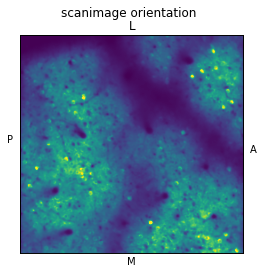

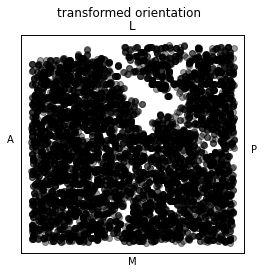

In [177]:
fig,ax = plt.subplots(figsize=(4,4))
ax.imshow(ims[0],vmin=np.percentile(ims[0],1),vmax = np.percentile(ims[0],99.9))
ax2 = ax.twinx()
ax.set_title('L')
ax.set_ylabel('P', rotation=0, labelpad=10)
ax2.set_ylabel('A', rotation=0, labelpad=10)
ax.set_xlabel('M')
ax.set_xticks([])
ax.set_yticks([])
ax2.set_yticks([])
fig.suptitle('scanimage orientation')

fig,ax = plt.subplots(figsize=(4,4))
ax.scatter(xs,ys,
            facecolor='k', alpha=0.4,
            edgecolor='k')
ax2 = ax.twinx()
ax.set_title('L')
ax.set_ylabel('A', rotation=0, labelpad=10)
ax2.set_ylabel('P', rotation=0, labelpad=10)
ax.set_xlabel('M')
ax.set_xticks([])
ax.set_yticks([])
ax2.set_yticks([])
ax.invert_yaxis()
fig.suptitle('transformed orientation')

# Transform

In [178]:
# FLIP in order to move into A to P left to right, L to M back to front 
ims_mod = np.flip(np.stack(ims),axis=2)
xs_mod = ph - xs


In [2]:
fig,ax = plt.subplots(figsize=(4,4))
ax.imshow(ims_mod[0],vmin=np.percentile(ims_mod[0],1),vmax = np.percentile(ims_mod[0],99.9))
ax2 = ax.twinx()
ax.set_title('L')
ax.set_ylabel('A', rotation=0, labelpad=10)
ax2.set_ylabel('P', rotation=0, labelpad=10)
ax.set_xlabel('M')
ax.set_xticks([])
ax.set_yticks([])
ax2.set_yticks([])
fig.suptitle('transformed orientation')

fig,ax = plt.subplots(figsize=(4,4))
ax.scatter(xs_mod,ys,
            facecolor='k', alpha=0.4,
            edgecolor='k')
# ax.imshow(ims_mod[0],vmin=np.percentile(ims_mod[0],1),vmax = np.percentile(ims_mod[0],99.9))
ax2 = ax.twinx()
ax.set_title('L')
ax.set_ylabel('A', rotation=0, labelpad=10)
ax2.set_ylabel('P', rotation=0, labelpad=10)
ax.set_xlabel('M')
ax.set_xticks([])
ax.set_yticks([])
ax2.set_yticks([])
ax.invert_yaxis()
fig.suptitle('transformed orientation')

NameError: name 'plt' is not defined

In [ ]:
rstride,cstride=5,5

transition = expit(np.linspace(-10,10,pw))

fig = plt.figure(figsize=(15,10),dpi=300,facecolor='none')
ax1 = fig.add_subplot(2, 3, 1, projection='3d',facecolor='none')
ax2 = fig.add_subplot(2, 3, 2, projection='3d',facecolor='none')
ax3 = fig.add_subplot(2, 3, 3, projection='3d',facecolor='none')
ax4 = fig.add_subplot(2, 3, 4, projection='3d',facecolor='none')
ax5 = fig.add_subplot(2, 3, 5, projection='3d',facecolor='none')
ax6 = fig.add_subplot(2, 3, 6, projection='3d',facecolor='none')

vmin = np.nanpercentile(np.hstack(ims_mod),1)
vmax = np.nanpercentile(np.hstack(ims_mod),99)

for i,(im_z, im) in enumerate(zip(im_zs[::-1],ims_mod[::-1])):
    plt_im = np.zeros((pw,ph,4))
    plt_im[:,:,1] = im
    plt_im -= vmin
    plt_im /= vmax
    plt_im = np.clip(plt_im,0,1)

    # create meshgrid and plot top (XY) image per scan field
#     X, Y = np.meshgrid(np.linspace(-uw/2,uw/2,pw), np.linspace(-uh/2,uh/2,ph))
    X, Y = np.meshgrid(np.arange(0,pw)+0.5, np.arange(0,ph)+0.5)
    
    plt_im[:,:,-1] = 1
    ax1.plot_surface(X,Y,np.full_like(X,im_z),
                     rstride=rstride,cstride=cstride,
                     facecolors=plt_im,shade=False)
    
    ax3.plot_surface(X[:,:int(pw/2)],Y[:,:int(pw/2)],np.full_like(X[:,:int(pw/2)],im_z),
                    rstride=rstride,cstride=cstride,
                     facecolors=plt_im,shade=False)
    
    if i == 0:
        ax4.plot_surface(X,Y,np.full_like(X,im_z),
                     rstride=rstride,cstride=cstride,
                     facecolors=plt_im,shade=False)
        
    else:
        ax4.plot_surface(X[:,:int(pw/2)],Y[:,:int(pw/2)],np.full_like(X[:,:int(pw/2)],im_z),
                    rstride=rstride,cstride=cstride,
                     facecolors=plt_im,shade=False)
    
    ax5.plot_surface(X[:,:int(pw/2)],Y[:,:int(pw/2)],np.full_like(X[:,:int(pw/2)],im_z),
                    rstride=rstride,cstride=cstride,
                     facecolors=plt_im,shade=False)
    ax5.plot_surface(X[:int(ph/2),int(pw/2):],Y[:int(ph/2),int(pw/2):],np.full_like(X[:int(ph/2),int(pw/2):],im_z),
                    rstride=rstride,cstride=cstride,
                     facecolors=plt_im,shade=False)
    
    plt_im[:,:,-1] = 1-(np.ones(ph)[:,None] * transition[None,:])
    ax6.plot_surface(X,Y,np.full_like(X,im_z),
                     rstride=rstride,cstride=cstride,
                     facecolors=plt_im,shade=False)
    
    
    
    

ax2.scatter(xs_mod,ys,zs,'o',
            facecolor='r', alpha=0.8,s=.05,
            edgecolor='r')

ax3.scatter(xs_mod[xs_mod>pw/2],ys[xs_mod>pw/2],zs[xs_mod>pw/2],'.',
            facecolor='r', alpha=0.8,s=.05,
            edgecolor='r')

ax4.scatter(xs_mod[xs_mod>pw/2],ys[xs_mod>pw/2],zs[xs_mod>pw/2],'.',
            facecolor='r', alpha=0.8,s=.05,
            edgecolor='r')
cutaway_mask = np.logical_and(xs_mod>pw/2,ys>ph/2)
ax5.scatter(xs_mod[cutaway_mask],ys[cutaway_mask],zs[cutaway_mask],'.',
            facecolor='r', alpha=0.8,s=.05,
            edgecolor='r')

x2alpha = interp1d(np.arange(pw),transition)

for x,y,z,a in zip(xs_mod,ys,zs,x2alpha(xs_mod)):
    ax6.scatter(x,y,z,'o',
               facecolor='r', alpha = a ,s=.05,
               edgecolor='r')


# set_axes_equal(ax)
# ax.invert_yaxis()
# ax.invert_xaxis()
# ax.invert_zaxis()
# ax.set_axis_off()
# ax.set_facecolor('none')
    
for ax in (ax1,ax2,ax3,ax4,ax5,ax6):
    
    # set axis equal so 1 px equal size in all dimensions
    set_axes_equal(ax)

    # flip y and z axis (turn axis on to see)
    ax.invert_zaxis()
    ax.set_ylim(ph+1,-1) #invert_yaxis bugged in matplotlib 3d
    ax.axis('off') 

# ax1.set_xlabel('x')
# ax1.set_ylabel('y')
# ax1.set_zlabel('z')

# ax1.set_facecolor('none')
# fig.tight_layout()
# title = str(animal_key['animal_id']) + '_stack_block.png'

# plt.savefig('two_photon_volume.png', dpi=300, facecolor='none')
plt.show()


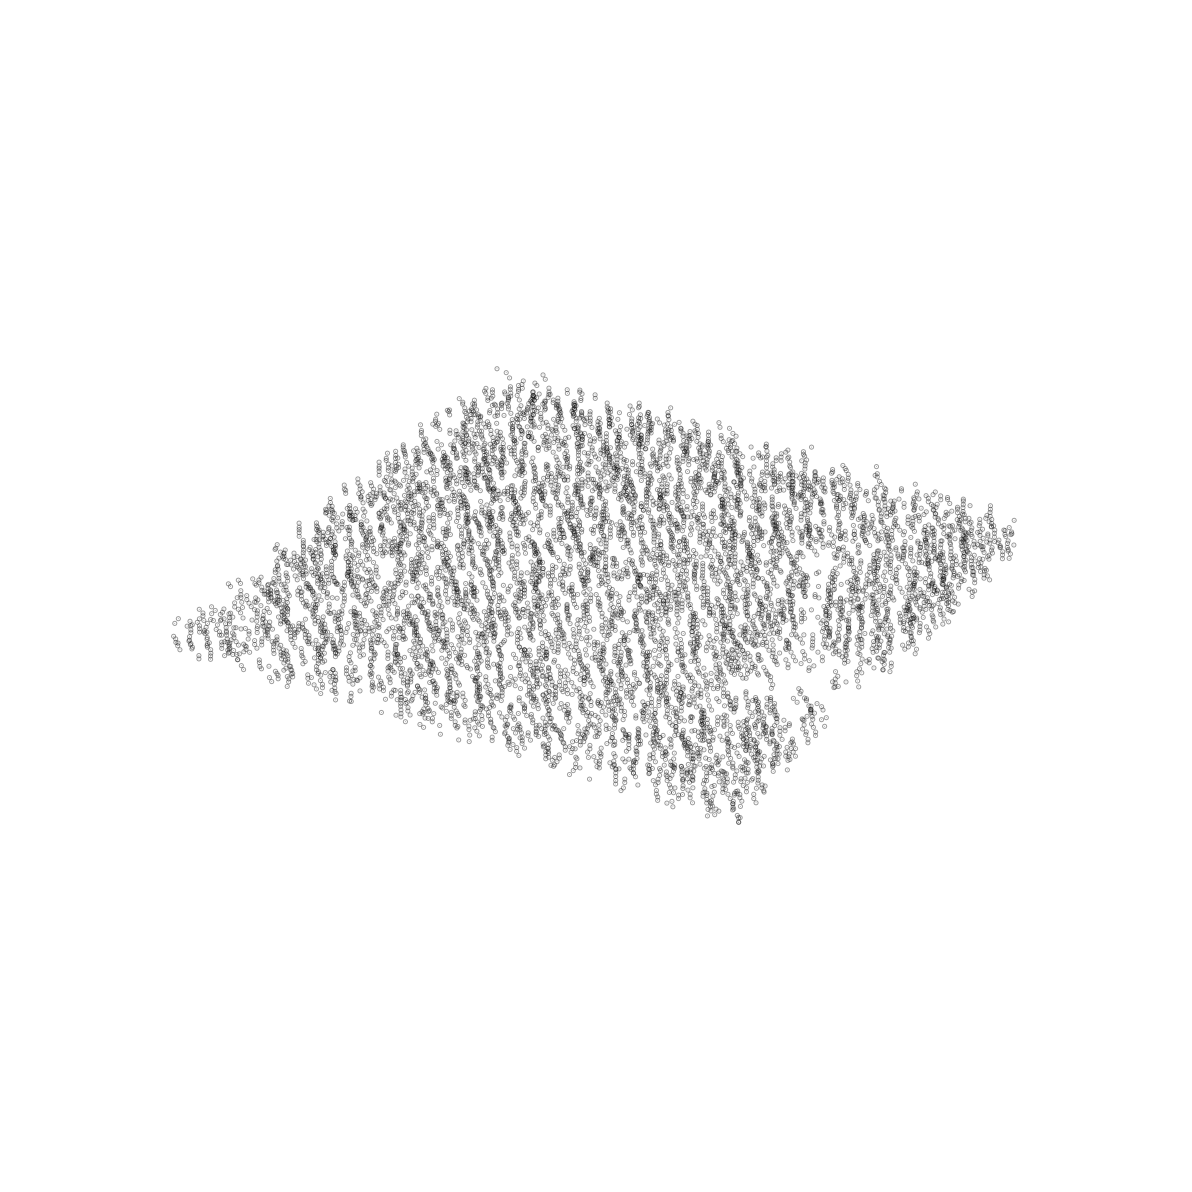

In [74]:
fig = plt.figure(figsize=(5,5),dpi=300,facecolor='none')
ax = plt.gca(projection='3d')

ax.scatter(xs,ys,zs,'o',
           facecolor='k', alpha=0.4,s=.05,
           edgecolor='k')
set_axes_equal(ax)
ax.invert_yaxis()
ax.invert_xaxis()
ax.invert_zaxis()
ax.set_axis_off()
ax.set_facecolor('none')

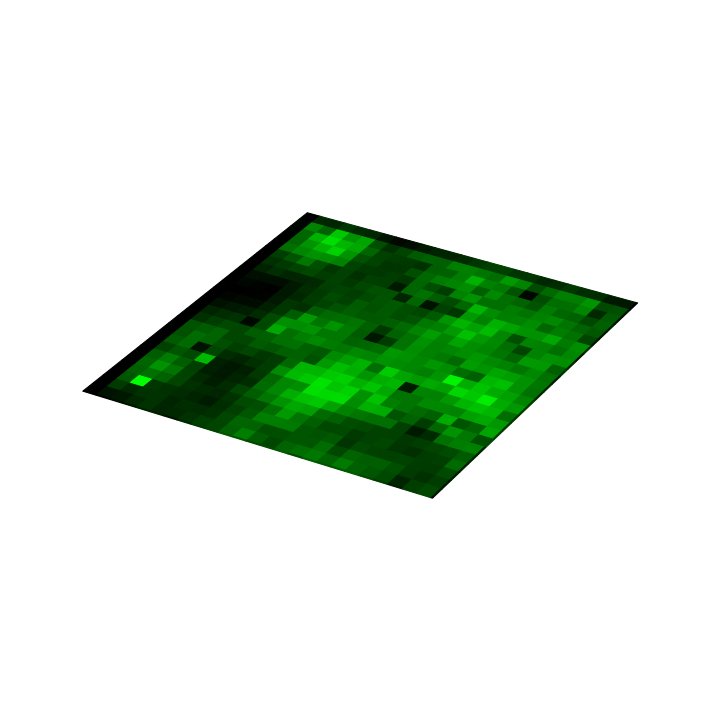

In [21]:
fig = plt.figure(figsize=(10,10),facecolor='none')
ax = plt.gca(projection='3d')

vmin = np.nanpercentile(np.hstack(ims),1)
vmax = np.nanpercentile(np.hstack(ims),99)
    
rstride,cstride=10,10

for z, im in zip(zs,ims[:1]):
    plt_im = np.zeros((pw,ph,3))
    plt_im[:,:,1] = np.flip(im,axis=(1))
    plt_im -= vmin
    plt_im /= vmax
    plt_im = np.clip(plt_im,0,1)

    # create meshgrid and plot top (XY) image per scan field
    X, Y = np.meshgrid(np.linspace(-uw/2,uw/2,pw), np.linspace(-uh/2,uh/2,ph))
    ax.plot_surface(X,Y,np.full_like(X,z),rstride=rstride,cstride=cstride,facecolors=plt_im,shade=False)
    
# set axis equal so 1 px equal size in all dimensions
set_axes_equal(ax)

# flip y and z axis (turn axis on to see)
ax.invert_zaxis()
ax.set_ylim(uh/2+1,-uh/2-1) #invert_yaxis bugged in matplotlib 3d
ax.axis('off') 

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.set_facecolor('none')
fig.tight_layout()
# title = str(animal_key['animal_id']) + '_stack_block.png'

# plt.savefig('two_photon_volume.png', dpi=300, facecolor='none')
plt.show()


# Transform

In [6]:
# TRANSPOSE and FLIP in order to move into M to L left to right, P to A back to front
# g_stack_mod = np.flip(g_stack.transpose([0,2,1]),axis=(1,2))

# FLIP in order to move into A to P left to right, L to M back to front 
g_stack_mod = np.flip(g_stack,axis=(2))

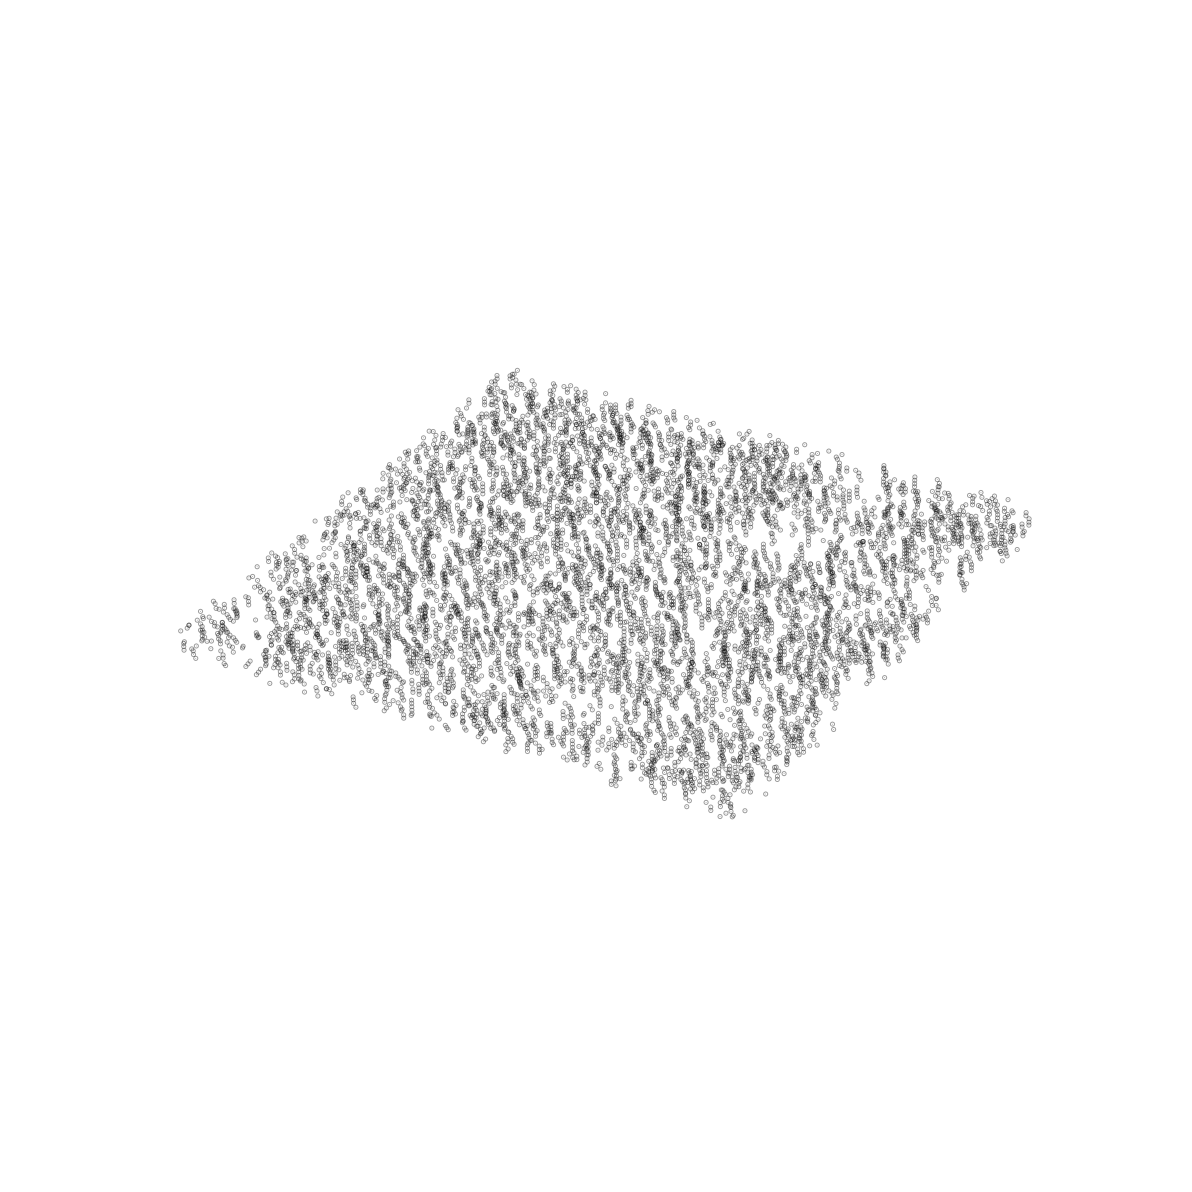

In [15]:
xs,ys,zs = (meso.StackCoordinates.UnitInfo & (nda.Scan & stack_key) & stack_key).fetch('stack_x','stack_y','stack_z')
xs,ys,zs = [c-np.mean(c) for c in (xs,ys,zs)]

fig = plt.figure(figsize=(5,5),dpi=300,facecolor='none')
ax = plt.gca(projection='3d')

ax.scatter(xs,ys,zs,'o',
           facecolor='k', alpha=0.4,s=.05,
           edgecolor='k')
set_axes_equal(ax)
ax.invert_yaxis()
ax.invert_xaxis()
ax.invert_zaxis()
ax.set_axis_off()
ax.set_facecolor('none')

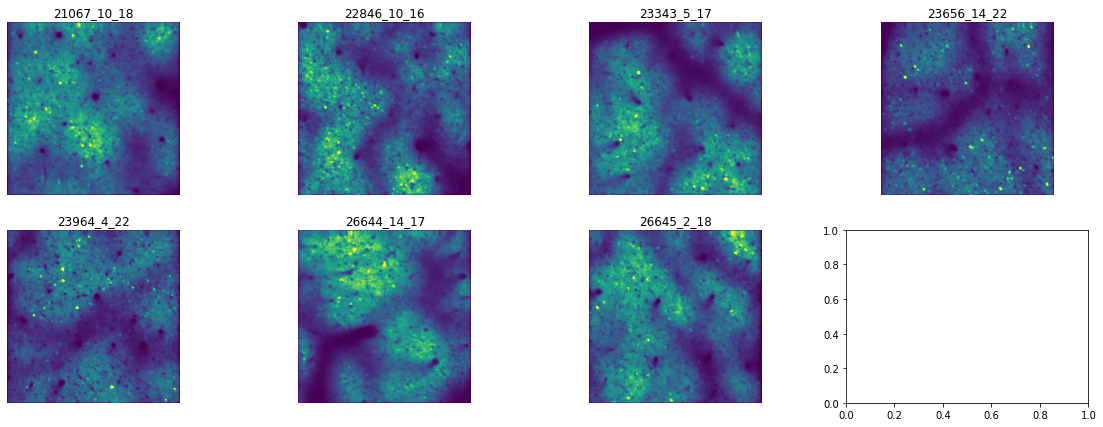

In [10]:
scan_key = list(nda.ScanInclude())[:1]

In [14]:
seg_rest = {'field':4, 'segmentation_method':6,'type':'soma'}
soma_masks = (meso.MaskClassification.Type & seg_rest)
fetch_str = ()
ph,pw = (meso.ScanInfo.Field & scan_key & seg_rest).fetch1('px_height','px_width')
ps,ws = (meso.Segmentation.Mask & soma_masks & scan_key).fetch('pixels','weights')
cum_mask = np.zeros((ph,pw))
for p,w in zip(ps,ws):
    cum_mask[np.unravel_index(p,(ph,pw),order='F')]+=w

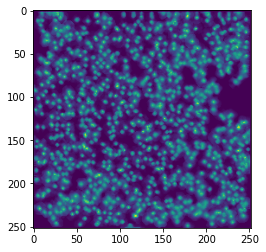

In [15]:
plt.imshow(cum_mask)

In [ ]:
for scan_key in nda.ScanInclude():
    soma_masks = (meso.Segmentation.Mask & soma_masks) * meso.ScanInfo.Field
    

In [ ]:
mask_key = {'animal_id':26872, 'session':7, 'scan_idx':18, 'field':1, 'segmentation_method':6}
soma_masks = (meso.MaskClassification.Type & mask_key) & 'type = "soma"'

ps,ws = (meso.Segmentation.Mask & soma_masks).fetch('pixels','weights')
ph,pw = (meso.ScanInfo.Field & mask_key).fetch1('px_height','px_width')


cum_rand_mask = np.zeros((ph,pw))
for p,w in zip(ps[rand_ids],ws[rand_ids]):
    cum_rand_mask[np.unravel_index(p,(ph,pw),order='F')] += w
cum_mask = np.zeros((ph,pw))
for p,w in zip(ps,ws):
    cum_mask[np.unravel_index(p,(ph,pw),order='F')] += w

    

In [ ]:
scan = (nda.Scan & {'animal_id':23656}).fetch1('KEY')
dim_strs = ['px_width','px_height','um_width','um_height']
pw,ph,uw,uh = (dj.U(*dim_strs) & (meso.ScanInfo.Field & scan)).fetch1(*dim_strs)
zs,ims = ((meso.ScanInfo.Field & scan) * meso.SummaryImages.Average).fetch('z','average_image',order_by='z ASC')
fig = plt.figure(figsize=(10,10),facecolor='none')
ax = plt.gca(projection='3d')

vmin = np.nanpercentile(np.hstack(ims),1)
vmax = np.nanpercentile(np.hstack(ims),99)
    
rstride,cstride=1,1

for z, im in zip(zs,ims):
    plt_im = np.zeros((pw,ph,3))
    plt_im[:,:,1] = np.flip(im,axis=(1))
    plt_im -= vmin
    plt_im /= vmax
    plt_im = np.clip(plt_im,0,1)

    # create meshgrid and plot top (XY) image per scan field
    X, Y = np.meshgrid(np.linspace(-uw/2,uw/2,pw), np.linspace(-uh/2,uh/2,ph))
    ax.plot_surface(X,Y,np.full_like(X,z),rstride=rstride,cstride=cstride,facecolors=plt_im,shade=False)
    
# set axis equal so 1 px equal size in all dimensions
set_axes_equal(ax)

# flip y and z axis (turn axis on to see)
ax.invert_zaxis()
ax.set_ylim(uh/2+1,-uh/2-1) #invert_yaxis bugged in matplotlib 3d
ax.axis('off') 

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.set_facecolor('none')
fig.tight_layout()
# title = str(animal_key['animal_id']) + '_stack_block.png'

# plt.savefig('two_photon_volume.png', dpi=300, facecolor='none')
plt.show()
